In [1]:
%%capture
#!pip install wfdb
BASEPATH = '../'
import sys
sys.path.insert(0,'../py')
print(sys.path)
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from utils import reset_seed, plot_spectogram, plot_loss, load_data
from utils import integer_mapping, mapping_AAMI, MAP_AAMI, INT_MAP_DICT
from data_handling import DataHandling
from data_preprocessing import DataPreprocessing
from report import Reports
from models.model_with_one_mhb import MultiHeadAttentionClassifier 

reset_seed()

In [8]:
dh = DataHandling(base_path='../data/')

dh.per_record_stats()

,A,N,a,R,S,V,F,j,E,e,L,J,Q
101,3,1860,0,0,0,0,0,0,0,0,0,0,2
106,0,1507,0,0,0,520,0,0,0,0,0,0,0
108,4,1739,0,0,0,17,2,1,0,0,0,0,0
109,0,0,0,0,0,38,2,0,0,0,2492,0,0
112,2,2537,0,0,0,0,0,0,0,0,0,0,0
114,10,1820,0,0,0,43,4,0,0,0,0,2,0
115,0,1953,0,0,0,0,0,0,0,0,0,0,0
116,1,2302,0,0,0,109,0,0,0,0,0,0,0
118,96,0,0,2166,0,16,0,0,0,0,0,0,0
119,0,1543,0,0,0,444,0,0,0,0,0,0,0


# Data

In [3]:
#Load Preprocessed data
x_train, y_train = load_data(file_path = '../data/DS1_features_train.dat')
#Load Preprocessed data
x_val, y_val = load_data(file_path = '../data/DS1_features_val.dat')
x_train.shape, len(y_train), x_val.shape, len(y_val)

File loaded: ../data/DS1_features_train.dat
File loaded: ../data/DS1_features_val.dat


((48664, 30, 40), 48664, (25500, 30, 40), 25500)

In [4]:
mean_train = np.mean(x_train)
std_train = np.std(x_train)

def stndr(arr,mean,std):
    X = arr.copy()
    X = (X - np.mean(X)) / np.std(X)
    return X

x_train = stndr(x_train,mean_train,std_train)
x_val = stndr(x_val,mean_train,std_train)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val  = train_test_split(features_train, y_train, 
                                                   test_size=0.30,stratify = y_train, 
                                                   random_state=142, shuffle=True)

In [5]:
dh = DataHandling()
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,19044,3948,3780,2008,2008,3682,2028,2025,2001,2050,2016,2070,0,0,2004
val,19043,1973,1890,8,8,1842,53,405,1,50,16,207,0,0,4


In [6]:
y_train = mapping_AAMI(y_train, MAP_AAMI)
y_val = mapping_AAMI(y_val, MAP_AAMI)

In [7]:
INT_MAP_DICT = {'N':0,'V':1,'S':1,'F':1,'Q':1}
y_train = integer_mapping(y_train, INT_MAP_DICT)
y_val = integer_mapping(y_val, INT_MAP_DICT)

# Train

In [7]:
params = {
    'seq_len' : x_train.shape[-2],
    'd_model' : x_train.shape[-1],
    'num_heads' : 2,
    'num_classes' : 2,
    'drate' : 0.15,
    'batch_size' : 256,
    'epochs' : 80
}
print(params)

{'seq_len': 30, 'd_model': 40, 'num_heads': 2, 'num_classes': 2, 'drate': 0.15, 'batch_size': 256, 'epochs': 80}


In [8]:
model_classifier  = MultiHeadAttentionClassifier(
                                            seq_len=params['seq_len'],
                                            d_model = params['d_model'],
                                            num_heads = params['num_heads'],
                                            num_classes=params['num_classes'],
                                            drate=params['drate']
                                            )

In [9]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam'
)

#for loss try sample_weight
model_classifier.compile(
                      optimizer=opt,
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'],
                      loss_weights=None
                      )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [10]:
%%time

model_history = model_classifier.fit(
              x=x_train,
              y=y_train,
              batch_size=params['batch_size'],
              epochs=params['epochs'],
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_val, y_val),
              shuffle=True,
              class_weight=None,
              sample_weight=None,
              initial_epoch=0
              )

Epoch 1/80
100/100 [==============================] - 8s 78ms/step - loss: 0.2059 - accuracy: 0.9391 - val_loss: 0.1220 - val_accuracy: 0.9639

Epoch 00001: val_loss improved from inf to 0.12197, saving model to ../checkpoint/keras.EXP1
Epoch 2/80
100/100 [==============================] - 7s 75ms/step - loss: 0.1197 - accuracy: 0.9647 - val_loss: 0.0864 - val_accuracy: 0.9746

Epoch 00002: val_loss improved from 0.12197 to 0.08645, saving model to ../checkpoint/keras.EXP1
Epoch 3/80
100/100 [==============================] - 8s 78ms/step - loss: 0.0968 - accuracy: 0.9719 - val_loss: 0.0808 - val_accuracy: 0.9756

Epoch 00003: val_loss improved from 0.08645 to 0.08077, saving model to ../checkpoint/keras.EXP1
Epoch 4/80
100/100 [==============================] - 9s 86ms/step - loss: 0.0892 - accuracy: 0.9744 - val_loss: 0.0793 - val_accuracy: 0.9769

Epoch 00004: val_loss improved from 0.08077 to 0.07927, saving model to ../checkpoint/keras.EXP1
Epoch 5/80
100/100 [====================

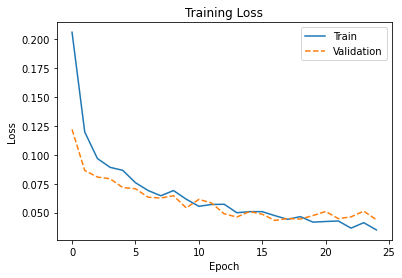

In [11]:
plot_loss(model_history)

In [12]:
import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)


In [13]:
a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

(0.04327202960848808, 16)

# Loading Model

In [14]:
loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
loaded_model.name

'multi_head_attention_classifier'

In [15]:
#loaded_model.summary()

In [16]:
#Load Preprocessed Test Set
x_test, y_test = load_data(file_path = '../data/DS2_features.dat')
y_true = y_test.copy()
x_test.shape, len(y_test)

File loaded: ../data/DS2_features.dat


((49693, 30, 40), 49693)

In [17]:
x_test = stndr(x_test,mean_train,std_train)

In [18]:
from data_handling import binarize_lables

y_true = binarize_lables(y_true,'N',pos=0,neg=1)

In [19]:
%%time
y_pred_prob = loaded_model.predict(x_test)

CPU times: user 6.55 s, sys: 178 ms, total: 6.73 s
Wall time: 6.37 s


In [20]:
y_pred_prob.shape

(49693, 2)

In [21]:
y_pred = integer_mapping(list(y_pred_prob.argmax(axis=-1)), {'N':0,'-':1}, inverse=True)
y_pred = binarize_lables(y_pred,'N',pos=0,neg=1)

In [22]:
dh = DataHandling()
rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
y_pred,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
y_true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
labels = [k for k,v in INT_MAP_DICT.items()]
report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
normalize = None
#report.plot_confusion_matrix(normalize=normalize, values_format='')
print(report.the_classification_report())
#report.metrics_table()


#y_pred_AAMI = mapping_AAMI(y_pred, MAP_AAMI)
#y_true_AAMI = mapping_AAMI(y_true, MAP_AAMI)
#labels_AAMI = ['N','V','S','F','Q']
#report = Reports(y_true=y_true_AAMI, y_pred=y_pred_AAMI, labels=labels_AAMI)
#report.plot_confusion_matrix(normalize=normalize, values_format='')
#print(report.the_classification_report())
#report.metrics_table()


              precision    recall  f1-score   support

           0     0.8084    0.9097    0.8560     36428
           1     0.6218    0.4078    0.4926     13265

    accuracy                         0.7757     49693
   macro avg     0.7151    0.6587    0.6743     49693
weighted avg     0.7586    0.7757    0.7590     49693



In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred),accuracy_score(y_true_AAMI,y_pred_AAMI)

NameError: name 'y_true_AAMI' is not defined